## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [6]:
import os
import keras
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [14]:
SGD = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95)
Adam = keras.optimizers.Adam(lr=LEARNING_RATE)
RMSprop = keras.optimizers.RMSprop(lr=LEARNING_RATE)

optimizer_set = [SGD,Adam,RMSprop]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.7,0.9]
redice_lr_patient = [5,10,25]

In [15]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, min_lr=1e-12,monitor='val_loss',patience=reduce_patient,verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("optimizer: %s,reduce_factor: %.2f, reduce_patient: %i" % (str(optim), reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 8/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.3930 - acc: 0.5122 - val_loss: 1.5454 - val_acc: 0.4519
Epoch 9/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.3672 - acc: 0.5223 - val_loss: 1.5375 - val_acc: 0.4644
Epoch 10/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.3369 - acc: 0.5338 - val_loss: 1.5148 - val_acc: 0.4651
Numbers of exp: 3, reduce_factor: 0.70, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hi

Epoch 5/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.5026 - acc: 0.4743 - val_loss: 1.6196 - val_acc: 0.4317
Epoch 6/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.4586 - acc: 0.4908 - val_loss: 1.5659 - val_acc: 0.4513
Epoch 7/10
50000/50000 [==============================] - 4s 78us/step - loss: 1.4218 - acc: 0.5031 - val_loss: 1.5449 - val_acc: 0.4589
Epoch 8/10
50000/50000 [==============================] - 4s 77us/step - loss: 1.3878 - acc: 0.5156 - val_loss: 1.5289 - val_acc: 0.4615
Epoch 9/10
50000/50000 [==============================] - 4s 77us/step - loss: 1.3577 - acc: 0.5247 - val_loss: 1.5423 - val_acc: 0.4619
Epoch 10/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.3307 - acc: 0.5356 - val_loss: 1.5073 - val_acc: 0.4728
Numbers of exp: 6, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape            

Epoch 2/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.7724 - acc: 0.3815 - val_loss: 1.8461 - val_acc: 0.3661
Epoch 3/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.6498 - acc: 0.4182 - val_loss: 1.7291 - val_acc: 0.4003
Epoch 4/10
50000/50000 [==============================] - 4s 75us/step - loss: 1.5774 - acc: 0.4458 - val_loss: 1.6704 - val_acc: 0.4139
Epoch 5/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.5227 - acc: 0.4660 - val_loss: 1.6164 - val_acc: 0.4345
Epoch 6/10
50000/50000 [==============================] - 4s 77us/step - loss: 1.4791 - acc: 0.4814 - val_loss: 1.6009 - val_acc: 0.4440
Epoch 7/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.4433 - acc: 0.4948 - val_loss: 1.5504 - val_acc: 0.4551
Epoch 8/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.4103 - acc: 0.5080 - val_loss: 1.5413 - val_acc: 0.4590
Epoch 9/10
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 130us/step - loss: 1.8120 - acc: 0.3630 - val_loss: 1.8343 - val_acc: 0.3734
Epoch 2/10
50000/50000 [==============================] - 4s 86us/step - loss: 1.5383 - acc: 0.4549 - val_loss: 1.6260 - val_acc: 0.4286
Epoch 3/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.4396 - acc: 0.4878 - val_loss: 1.7149 - val_acc: 0.3927
Epoch 4/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.3765 - acc: 0.5121 - val_loss: 1.7402 - val_acc: 0.3826
Epoch 5/10
50000/50000 [==============================] - 5s 99us/step - loss: 1.3176 - acc: 0.5324 - val_loss: 1.6547 - val_acc: 0.4268
Epoch 6/10
50000/50000 [==============================] - 4s 90us/step - loss: 1.2680 - acc: 0.5486 - val_loss: 1.5323 - val_acc: 0.4661
Epoch 7/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.2219 - acc: 0.5682 - val_loss: 1.4858 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 136us/step - loss: 1.8418 - acc: 0.3544 - val_loss: 1.8031 - val_acc: 0.3737
Epoch 2/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.5771 - acc: 0.4365 - val_loss: 1.6442 - val_acc: 0.4149
Epoch 3/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.4793 - acc: 0.4724 - val_loss: 1.6497 - val_acc: 0.4105
Epoch 4/10
50000/50000 [==============================] - 4s 83us/step - loss: 1.4155 - acc: 0.4952 - val_loss: 1.5361 - val_acc: 0.4519
Epoch 5/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.3605 - acc: 0.5143 - val_loss: 1.4983 - val_acc: 0.4607
Epoch 6/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.3123 - acc: 0.5360 - val_loss: 1.6571 - val_acc: 0.4087
Epoch 7/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.2674 - acc: 0.5493 - val_loss: 1.5113 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 143us/step - loss: 1.8425 - acc: 0.3578 - val_loss: 1.8613 - val_acc: 0.3674
Epoch 2/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.5764 - acc: 0.4372 - val_loss: 1.6427 - val_acc: 0.4118
Epoch 3/10
50000/50000 [==============================] - 5s 104us/step - loss: 1.4758 - acc: 0.4741 - val_loss: 1.6409 - val_acc: 0.4068
Epoch 4/10
50000/50000 [==============================] - 5s 91us/step - loss: 1.4097 - acc: 0.4984 - val_loss: 1.5625 - val_acc: 0.4567
Epoch 5/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.3500 - acc: 0.5190 - val_loss: 1.5850 - val_acc: 0.4362
Epoch 6/10
50000/50000 [==============================] - 4s 82us/step - loss: 1.2972 - acc: 0.5400 - val_loss: 1.5438 - val_acc: 0.4424
Epoch 7/10
50000/50000 [==============================] - 5s 93us/step - loss: 1.2581 - acc: 0.5543 - val_loss: 1.4964 - val_a

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 151us/step - loss: 1.8013 - acc: 0.3752 - val_loss: 1.9684 - val_acc: 0.3194
Epoch 2/10
50000/50000 [==============================] - 4s 83us/step - loss: 1.5203 - acc: 0.4653 - val_loss: 2.6248 - val_acc: 0.2931
Epoch 3/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.4119 - acc: 0.5026 - val_loss: 2.1898 - val_acc: 0.3146
Epoch 4/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.3372 - acc: 0.5291 - val_loss: 2.2237 - val_acc: 0.3119
Epoch 5/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.2732 - acc: 0.5535 - val_loss: 2.1565 - val_acc: 0.3367
Epoch 6/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.2124 - acc: 0.5745 - val_loss: 2.5224 - val_acc: 0.2747
Epoch 7/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.1719 - acc: 0.5901 - val_loss: 1.8203 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 144us/step - loss: 1.7976 - acc: 0.3787 - val_loss: 2.2810 - val_acc: 0.2929
Epoch 2/10
50000/50000 [==============================] - 4s 79us/step - loss: 1.5066 - acc: 0.4690 - val_loss: 2.1393 - val_acc: 0.3402
Epoch 3/10
50000/50000 [==============================] - 4s 79us/step - loss: 1.3991 - acc: 0.5030 - val_loss: 2.9649 - val_acc: 0.2588
Epoch 4/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.3252 - acc: 0.5340 - val_loss: 1.7888 - val_acc: 0.4022
Epoch 5/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.2562 - acc: 0.5592 - val_loss: 1.6932 - val_acc: 0.4156
Epoch 6/10
50000/50000 [==============================] - 4s 82us/step - loss: 1.2077 - acc: 0.5773 - val_loss: 1.9579 - val_acc: 0.3499
Epoch 7/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.1543 - acc: 0.5953 - val_loss: 1.8712 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 150us/step - loss: 1.8086 - acc: 0.3743 - val_loss: 2.3193 - val_acc: 0.2982
Epoch 2/10
50000/50000 [==============================] - 4s 83us/step - loss: 1.5196 - acc: 0.4664 - val_loss: 2.4052 - val_acc: 0.2796
Epoch 3/10
50000/50000 [==============================] - 4s 86us/step - loss: 1.4061 - acc: 0.5043 - val_loss: 1.8214 - val_acc: 0.3649
Epoch 4/10
50000/50000 [==============================] - 5s 102us/step - loss: 1.3277 - acc: 0.5315 - val_loss: 1.8507 - val_acc: 0.3775
Epoch 5/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.2661 - acc: 0.5558 - val_loss: 3.7812 - val_acc: 0.1665
Epoch 6/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.2056 - acc: 0.5780 - val_loss: 1.7427 - val_acc: 0.3986
Epoch 7/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.1559 - acc: 0.5961 - val_loss: 1.7447 - val_

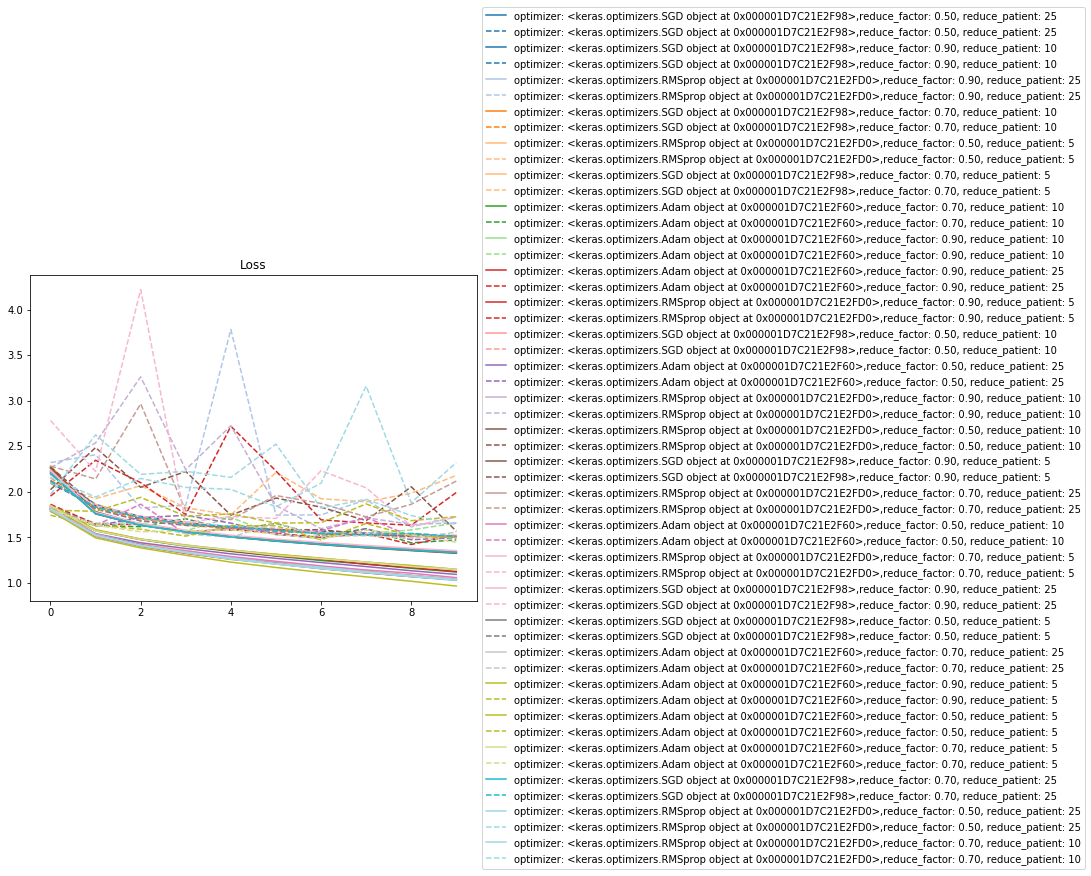

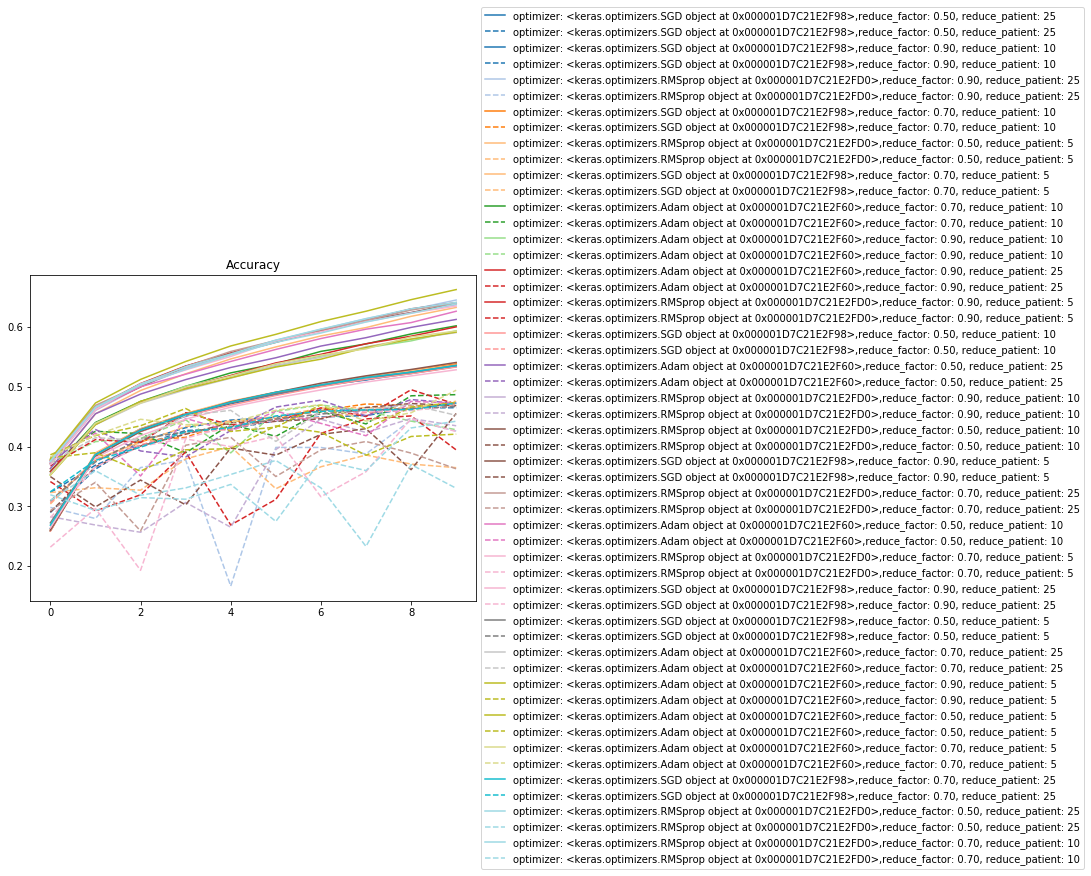

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('tab20')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()